<a href="https://colab.research.google.com/github/raminazari/financial-model/blob/main/gonbad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                               Close  Cumulative Return
Date                                                   
2020-01-02 00:00:00-05:00  72.716064                NaN
2020-01-03 00:00:00-05:00  72.009117           0.990278
2020-01-06 00:00:00-05:00  72.582909           0.998169
2020-01-07 00:00:00-05:00  72.241554           0.993474
2020-01-08 00:00:00-05:00  73.403648           1.009456


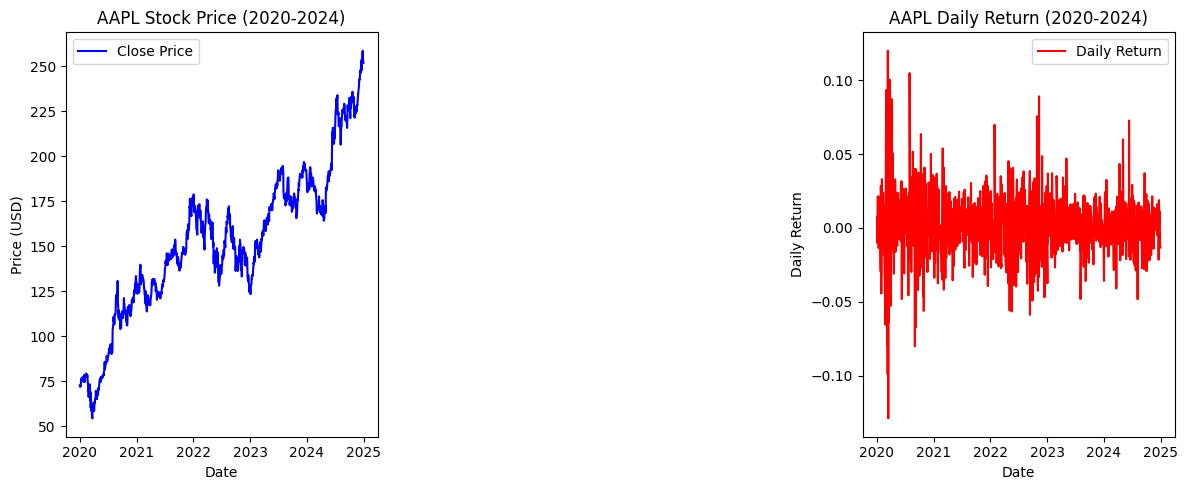

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# دریافت داده‌های سهام اپل از یاهو فایننس
aapl = yf.Ticker("AAPL")

# دانلود داده‌های تاریخی از 2020 تا 2024
data = aapl.history(start="2020-01-01", end="2024-12-31")

# محاسبه بازدهی روزانه و تجمعی
data['Daily Return'] = data['Close'].pct_change()
data['Cumulative Return'] = (1 + data['Daily Return']).cumprod()

# نمایش داده‌های اولیه
print(data[['Close', 'Cumulative Return']].head())

# رسم نمودار قیمت بسته شدن، بازدهی تجمعی و بازدهی روزانه
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('AAPL Stock Price (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()



plt.subplot(1, 3, 3)
plt.plot(data.index, data['Daily Return'], label='Daily Return', color='red')
plt.title('AAPL Daily Return (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()

plt.tight_layout()
plt.show()


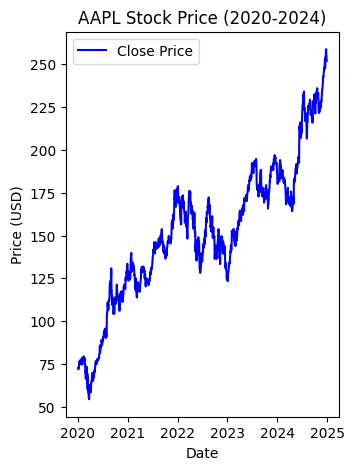

In [ ]:
# رسم نمودار قیمت بسته شدن، بازدهی تجمعی و بازدهی روزانه
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('AAPL Stock Price (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()


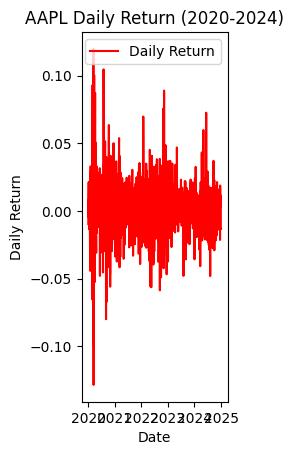

In [ ]:
plt.subplot(1, 3, 3)
plt.plot(data.index, data['Daily Return'], label='Daily Return', color='red')
plt.title('AAPL Daily Return (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()


<ipython-input-127-820454facce7>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Return'] = predicted_returns


,Predicted Return
Date,
2024-07-11 00:00:00-04:00,-0.015263
2024-07-12 00:00:00-04:00,-0.007492
2024-07-15 00:00:00-04:00,-0.026242
2024-07-16 00:00:00-04:00,-0.016436
2024-07-17 00:00:00-04:00,-0.001585
...,...
2024-11-21 00:00:00-05:00,0.008664
2024-11-22 00:00:00-05:00,0.014931
2024-11-25 00:00:00-05:00,0.026585


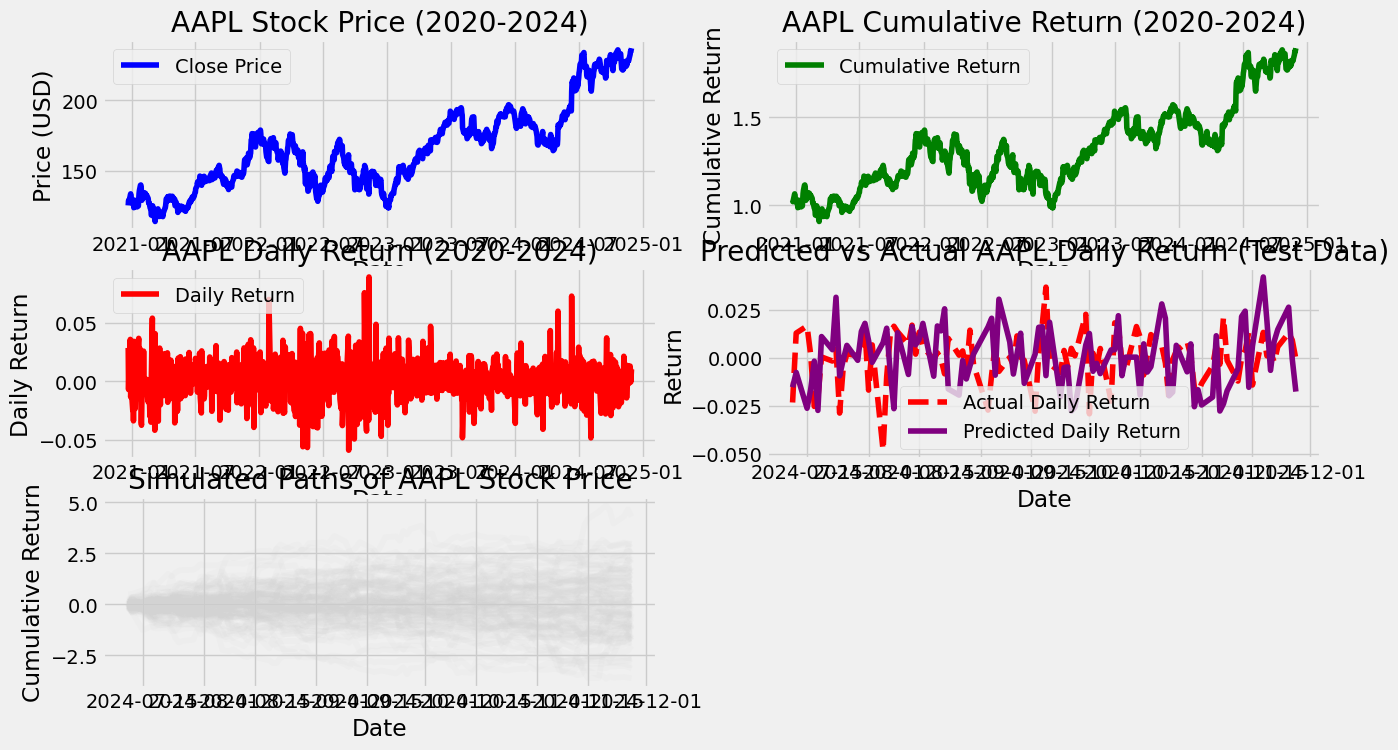

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.optimize import minimize
import numpy as np

# دریافت داده‌های سهام اپل از یاهو فایننس
aapl = yf.Ticker("AAPL")

# دانلود داده‌های تاریخی از 2020 تا 2024
data = aapl.history(start="2020-12-20", end="2024-12-01").dropna()

# محاسبه بازدهی روزانه و تجمعی
data['Daily Return'] = data['Close'].pct_change()
data['Cumulative Return'] = (1 + data['Daily Return']).cumprod()

# تقسیم داده‌ها به 90% آموزش و 10% آزمایش
train_size = int(len(data) * 0.9)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# مدل هستون برای پیش‌بینی نوسانات
def heston_log_likelihood(params, returns):
    kappa, theta, sigma, v0, rho = params
    n = len(returns)
    v = np.zeros(n)
    v[0] = max(v0, 1e-8)  # جلوگیری از مقدار منفی یا صفر در مقدار اولیه
    log_likelihood = 0

    for t in range(1, n):
        v[t] = max(v[t-1] + kappa * (theta - v[t-1]) + sigma * sqrt(max(v[t-1], 1e-8)) * np.random.normal(), 1e-8)
        log_likelihood += -0.5 * (np.log(v[t]) + (returns.iloc[t] ** 2) / v[t])

    return -log_likelihood

# مقداردهی اولیه پارامترهای مدل هستون
initial_params = [0.1, 0.02, 0.1, 0.02, 0.5]
result = minimize(heston_log_likelihood, initial_params, args=(train_data['Daily Return'].dropna(),), method='Nelder-Mead')
kappa, theta, sigma, v0, rho = result.x



# شبیه‌سازی مسیرهای آینده با مدل هستون
simulations = 100  # تعداد شبیه‌سازی‌ها ثابت می‌ماند
future_days = len(test_data) - 1  # تعداد روزهای پیش‌بینی را ۱ واحد کاهش دهید
simulated_returns = np.zeros((simulations, future_days))

for i in range(simulations):
    v = v0
    for t in range(future_days):
        v = max(v + kappa * (theta - v) + sigma * sqrt(max(v, 1e-8)) * np.random.normal(), 1e-8)
        simulated_returns[i, t] = np.random.normal(0, sqrt(v))

# محاسبه میانگین بازدهی پیش‌بینی‌شده
predicted_returns = simulated_returns.mean(axis=0)

# مقایسه بازدهی پیش‌بینی شده با داده واقعی
# توجه: از آنجایی که تعداد روزهای پیش‌بینی کاهش یافته، باید `test_data` را نیز برش دهید
test_data = test_data.iloc[:future_days]  # کاهش طول `test_data` به اندازه‌ی `future_days`
test_data['Predicted Return'] = predicted_returns

# رسم نمودار قیمت بسته شدن، بازدهی تجمعی، بازدهی روزانه و پیش‌بینی بازدهی روزانه
plt.figure(figsize=(14, 8))

# قیمت بسته شدن
plt.subplot(3, 2, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('AAPL Stock Price (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

# بازدهی تجمعی
plt.subplot(3, 2, 2)
plt.plot(data.index, data['Cumulative Return'], label='Cumulative Return', color='green')
plt.title('AAPL Cumulative Return (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

# بازدهی روزانه
plt.subplot(3, 2, 3)
plt.plot(data.index, data['Daily Return'], label='Daily Return', color='red')
plt.title('AAPL Daily Return (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()

# پیش‌بینی بازدهی روزانه در برابر بازدهی واقعی
plt.subplot(3, 2, 4)
plt.plot(test_data.index, test_data['Daily Return'], label='Actual Daily Return', color='red', linestyle='dashed')
plt.plot(test_data.index, test_data['Predicted Return'], label='Predicted Daily Return', color='purple')
plt.title('Predicted vs Actual AAPL Daily Return (Test Data)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()

# نمایش تمام مسیرها
plt.subplot(3, 2, 5)
for i in range(simulations):
    plt.plot(test_data.index, np.cumsum(simulated_returns[i, :]), color='lightgray', alpha=0.1)
plt.title('Simulated Paths of AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')

test_data['Predicted Return']

In [ ]:
# نمایش ضرایب بهینه‌شده
print("ضرایب بهینه‌شده:")
print(f"kappa: {kappa}")
print(f"theta: {theta}")
print(f"sigma: {sigma}")
print(f"v0: {v0}")
print(f"rho: {rho}")

# نمایش نمودارها
plt.tight_layout()
plt.show()


ضرایب بهینه‌شده:
kappa: 0.10106331791041864
theta: 0.0204179594469985
sigma: 0.0991547440671573
v0: 0.020347788693831484
rho: 0.5006136339134268


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# محاسبه خطاها
mse = mean_squared_error(test_data['Daily Return'], test_data['Predicted Return'])
rmse = sqrt(mse)  # RMSE برابر است با جذر MSE
mae = mean_absolute_error(test_data['Daily Return'], test_data['Predicted Return'])

# نمایش خطاها
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE: 0.00040630228373498845
RMSE: 0.020156941328857127
MAE: 0.016289856479465657


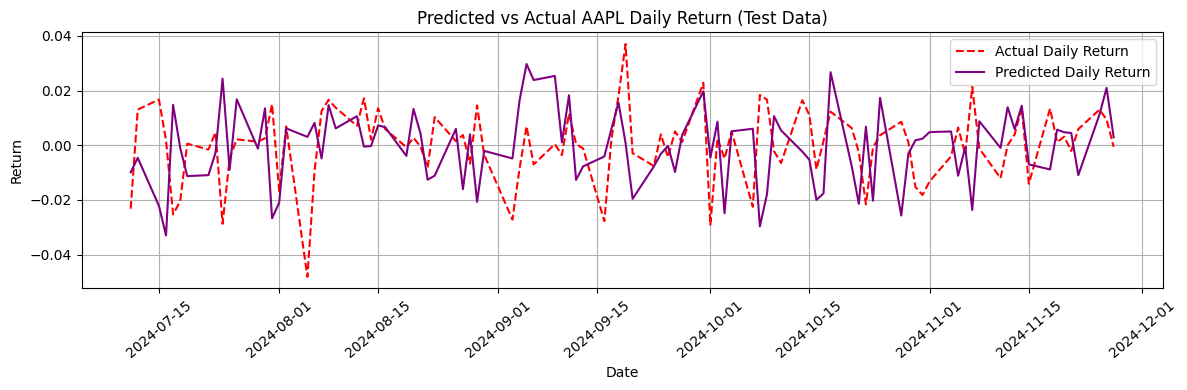

In [ ]:
import matplotlib.pyplot as plt

# فرض کنید test_data یک DataFrame است و شامل ستون‌های 'Daily Return' و 'Predicted Return' است
# همچنین تاریخ‌ها به عنوان index در test_data تعریف شده‌اند

# رسم نمودار با تاریخ‌ها
plt.figure(figsize=(12, 4))  # تنظیم اندازه نمودار
plt.plot(test_data.index, test_data['Daily Return'], label='Actual Daily Return', color='red', linestyle='dashed')
plt.plot(test_data.index, test_data['Predicted Return'], label='Predicted Daily Return', color='purple')
plt.title('Predicted vs Actual AAPL Daily Return (Test Data)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()  # نمایش راهنما (legend)
plt.grid(True)  # نمایش شبکه‌بندی
plt.xticks(rotation=40)  # چرخش برچسب‌های محور x برای خوانایی بهتر
plt.tight_layout()  # جلوگیری از بریده شدن برچسب‌ها
plt.show()

In [ ]:
test_data['Daily Return']

,Daily Return
Date,
2024-07-11 00:00:00-04:00,-0.023221
2024-07-12 00:00:00-04:00,0.013051
2024-07-15 00:00:00-04:00,0.016743
2024-07-16 00:00:00-04:00,0.001792
2024-07-17 00:00:00-04:00,-0.025296
...,...
2024-11-21 00:00:00-05:00,-0.002096
2024-11-22 00:00:00-05:00,0.005908
2024-11-25 00:00:00-05:00,0.013051


In [ ]:
test_data['Predicted Return'].shape

(99,)

[*********************100%***********************]  1 of 1 completed


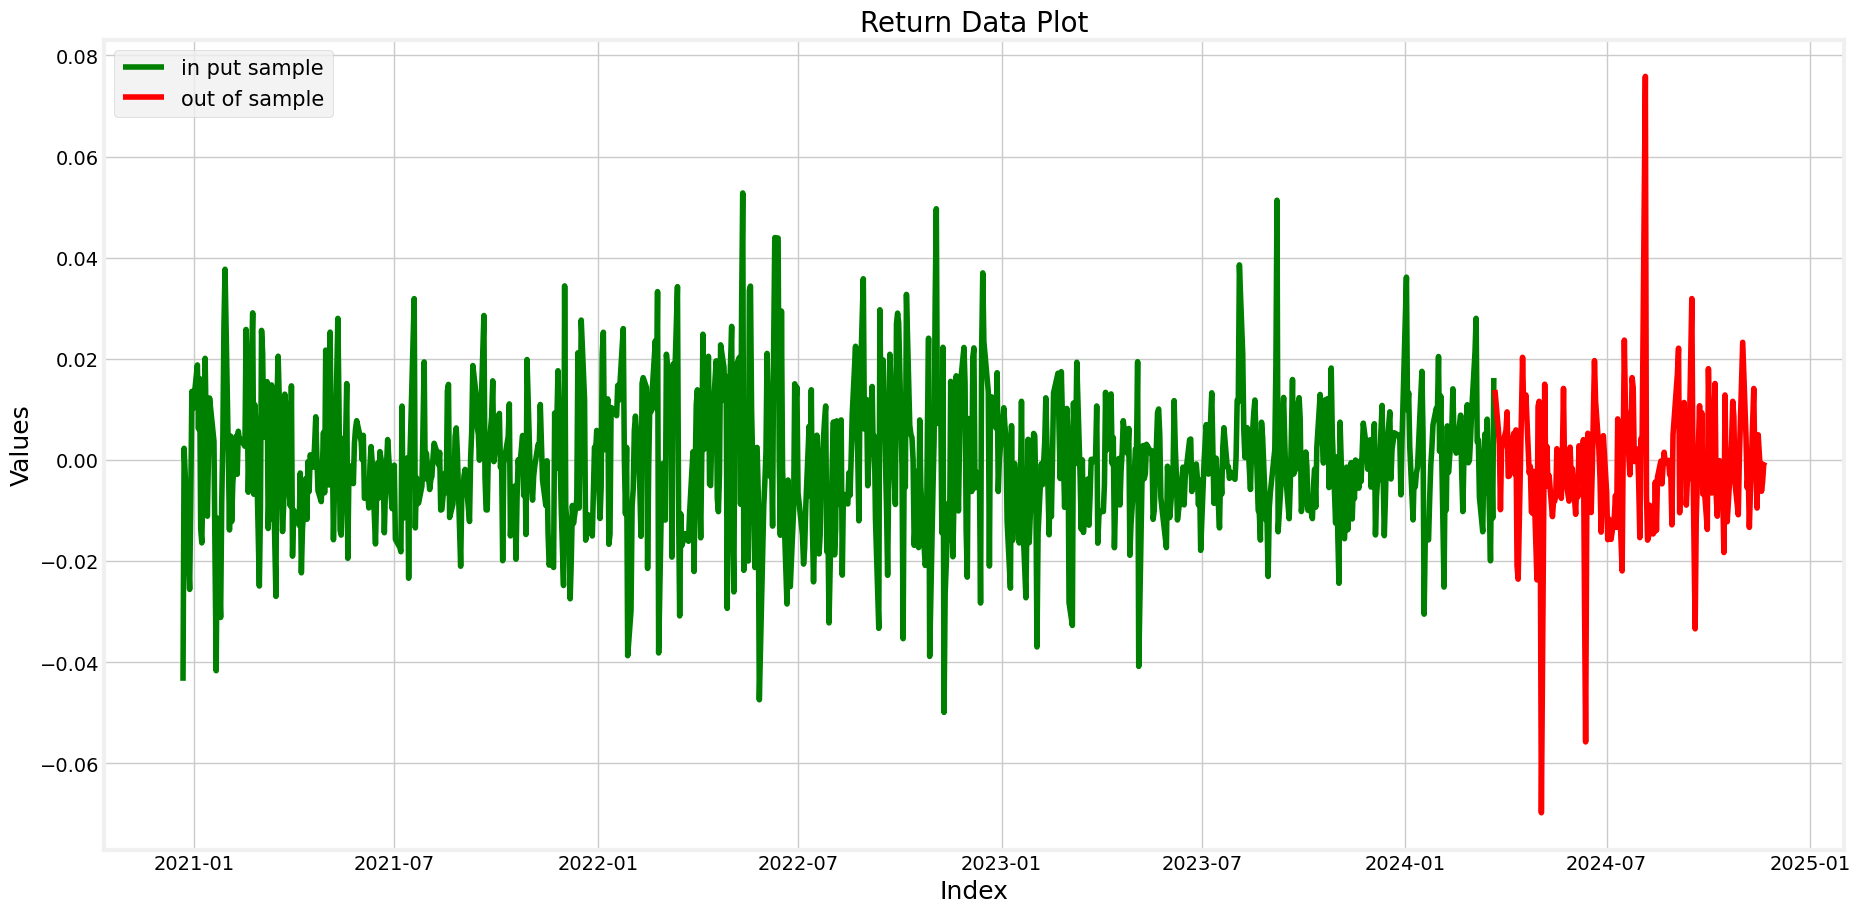

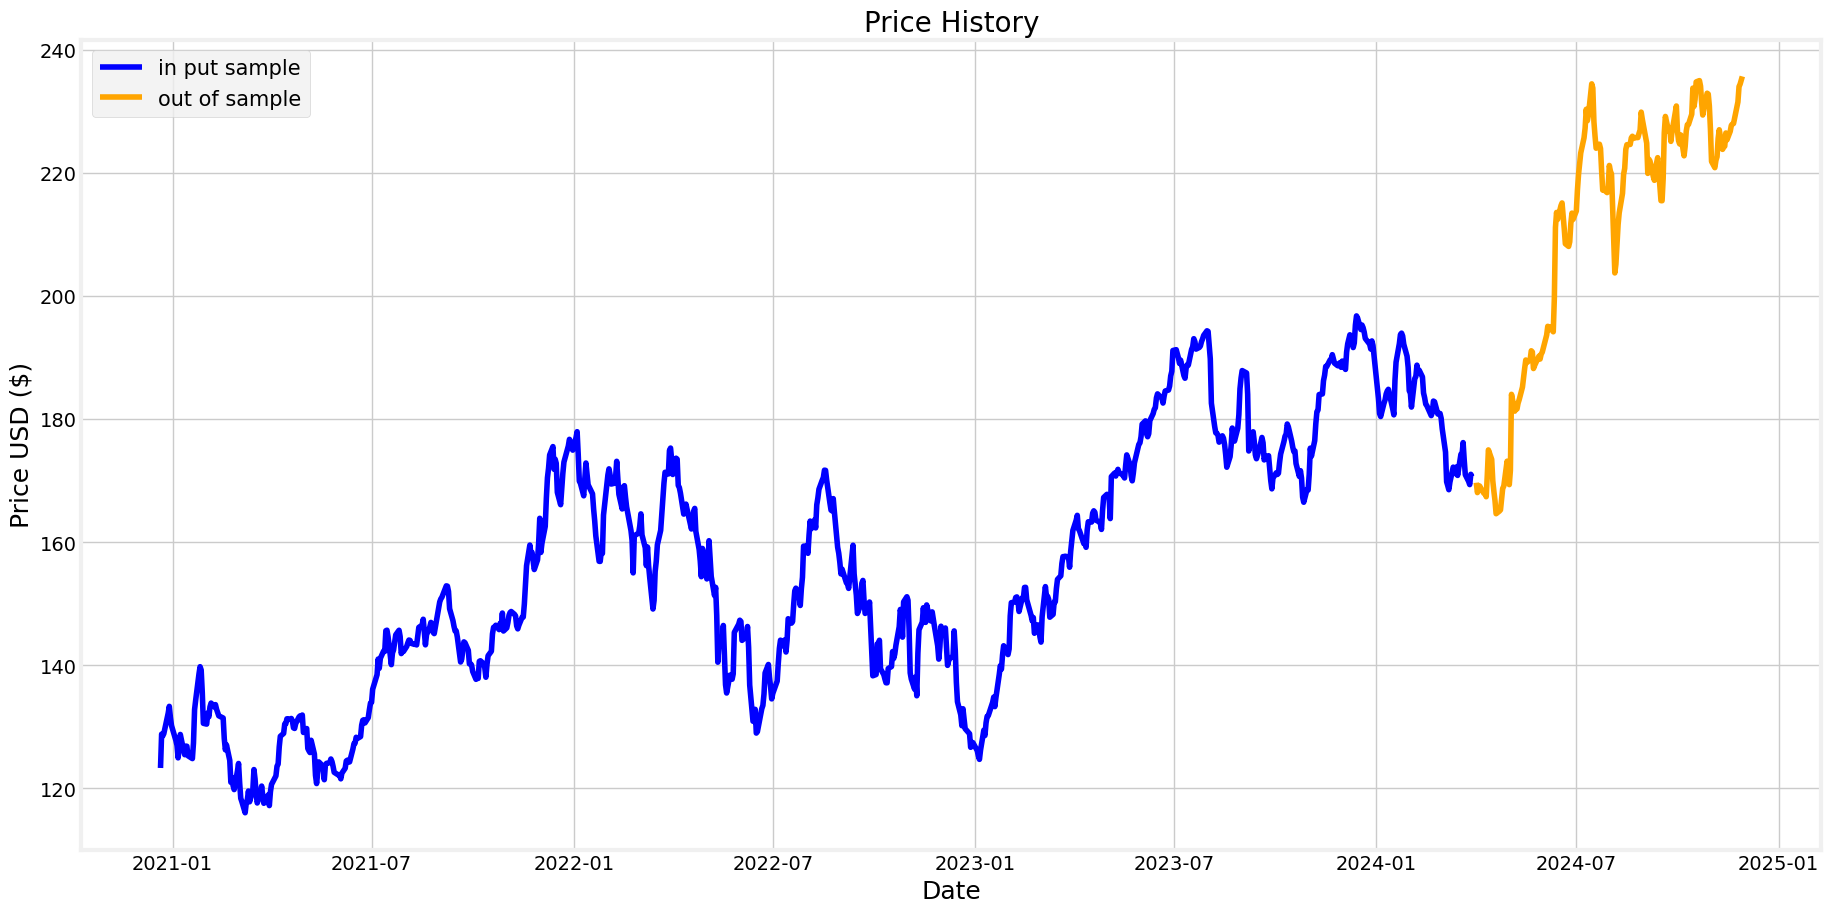

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.9280e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9651e-04 
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8212e-04  
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8482e-04 
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6551e-04 
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0373e-04 
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9365e-04 
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9190e-04 
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8675e-04  
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8616e-04  
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8432e-04  
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8121e-04 
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7700e-04 
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8745e-04 
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━

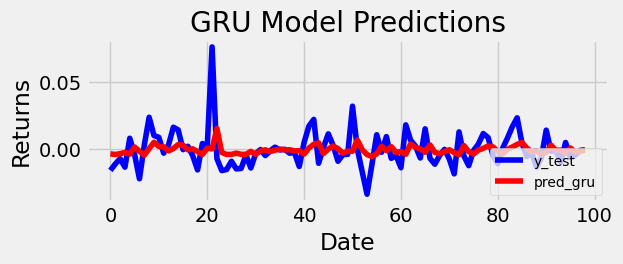

In [ ]:
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf
from scipy.stats import shapiro, chi2
from keras.layers import Dense, GRU
from keras.models import Sequential
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from numpy import array

# دانلود داده‌های AAPL از Yahoo Finance
dataset = yf.download("AAPL", start="2020-12-20", end="2024-12-01")
data1 = pd.DataFrame(dataset)
data1.to_csv("data1.csv")

# محاسبه میانگین قیمت‌های روزانه
nf = 5
data = data1.head(len(data1))
datasetC = (data['Close'] + data['Open'] + data['High'] + data['Low']) / 4

# محاسبه بازده لگاریتمی
datar1 = ((np.log(datasetC.astype('float64').shift(+1))) - np.log(datasetC.astype('float64')))
datar = datar1.tail(len(datar1) - 1)

# تقسیم داده‌ها به داده‌های آموزشی و داده‌های واقعی برای پیش‌بینی
returndata = datar.head(len(datar) - nf)
realdataf = datar.tail(nf)

# رسم نمودار بازده‌ها
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.plot(returndata.head(len(returndata) - 170), color='green', label='in put sample')
plt.plot(returndata.tail(170), color='red', label='out of sample')
plt.title('Return Data Plot', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Values', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

# رسم نمودار تاریخچه قیمت
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.plot(datasetC.head(len(datasetC) - 170), color='blue', label='in put sample')
plt.plot(datasetC.tail(170), color='orange', label='out of sample')
plt.title('Price History', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

# تبدیل داده‌ها به فرمت supervised
def to_supervised(train, n_input, n_out):
    data = train
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input)))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return array(X), array(y)

# تفاضل گیری از داده‌ها
def difference(returndata, interval=1):
    diff = list()
    for i in range(interval, len(returndata)):
        value = returndata[i] - returndata[i - interval]
        diff.append(value)
    return diff

# آماده‌سازی داده‌ها
dataset1 = np.array(returndata)
dataset_diff = difference(dataset1, 1)
dataset_diff = pd.DataFrame(dataset_diff)
dataset2 = np.array(returndata)
predreturn = np.reshape(dataset2, (dataset2.shape[0], 1))

# پارامترهای مدل
n_step = 1
lag = 1
X, y = to_supervised(predreturn, n_input=lag, n_out=n_step)

# تقسیم داده‌ها به داده‌های آموزشی و آزمون
split_percentage = 0.9
n_test = len(returndata) - int(split_percentage * len(returndata))
n_train = len(returndata) - n_test
x_train, x_test = X[:-n_test, :], X[-n_test:, :]
y_train, y_test = y[:-n_test, :], y[-n_test:, :]

# تغییر شکل داده‌ها برای GRU
x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# تعریف مدل GRU
model_gru = Sequential()
model_gru.add(GRU(64, activation='relu', input_shape=(x_train.shape[1], 1)))
model_gru.add(Dense(n_step, activation='selu'))
model_gru.compile(loss='mse', optimizer='adam')

# آموزش مدل
model_gru.fit(x_train_reshaped, y_train, epochs=100, batch_size=100)

# پیش‌بینی با مدل GRU
predict_gru = model_gru.predict(x_test_reshaped)

# محاسبه خطای MSE
mse_gru = mean_squared_error(y_test, predict_gru)
print("MSE for GRU model:", mse_gru)

# رسم نمودار پیش‌بینی‌ها
fig = plt.figure(figsize=(6, 2))
plt.plot(y_test, color='b', label='y_test')
plt.plot(predict_gru, color='r', label='pred_gru')
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('GRU Model Predictions')
plt.show()

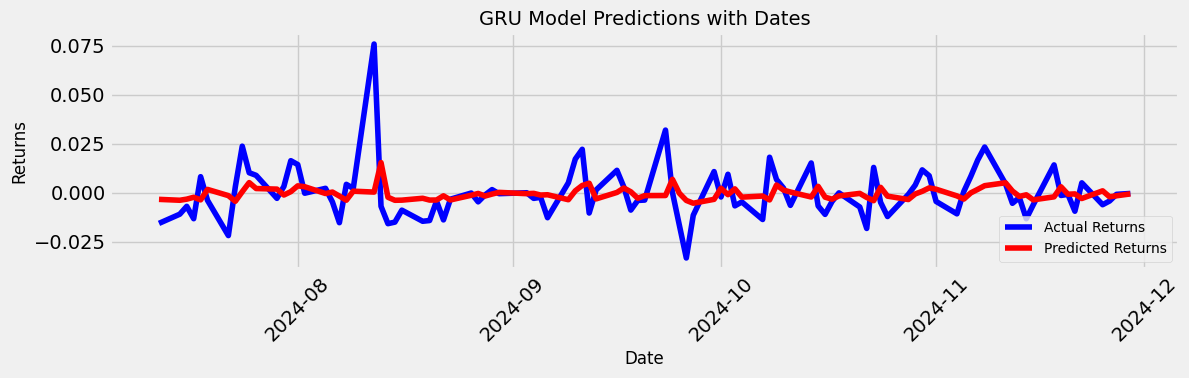

In [ ]:

# فرض کنید y_test و predict_gru به همراه تاریخ‌های مربوطه هستند
# اگر y_test و predict_gru به صورت آرایه‌های numpy هستند، ابتدا آن‌ها را به DataFrame تبدیل می‌کنیم
import pandas as pd

# تبدیل y_test و predict_gru به DataFrame و اختصاص تاریخ‌ها به عنوان شاخص
dates = data1.index[-n_test:]  # تاریخ‌های مربوط به داده‌های آزمون
y_test_df = pd.DataFrame(y_test, index=dates, columns=['Returns'])
predict_gru_df = pd.DataFrame(predict_gru, index=dates, columns=['Predicted Returns'])

# رسم نمودار با تاریخ‌ها
plt.figure(figsize=(12, 4))
plt.plot(y_test_df.index, y_test_df['Returns'], color='b', label='Actual Returns')
plt.plot(predict_gru_df.index, predict_gru_df['Predicted Returns'], color='r', label='Predicted Returns')
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.title('GRU Model Predictions with Dates', fontsize=14)
plt.xticks(rotation=45)  # چرخش برچسب‌های محور x برای خوانایی بهتر
plt.grid(True)
plt.tight_layout()  # برای جلوگیری از بریده شدن برچسب‌ها
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# فرض کنید y_test و predict_gru از قبل تعریف شده‌اند
# y_test: مقادیر واقعی بازدهی
# predict_gru: مقادیر پیش‌بینی‌شده توسط مدل GRU

# محاسبه خطاها
mse = mean_squared_error(y_test, predict_gru)  # محاسبه MSE
rmse = sqrt(mse)  # محاسبه RMSE (جذر MSE)
mae = mean_absolute_error(y_test, predict_gru)  # محاسبه MAE

# نمایش خطاها
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE: 0.00017069107993560037
RMSE: 0.013064879637241223
MAE: 0.00898756167487126


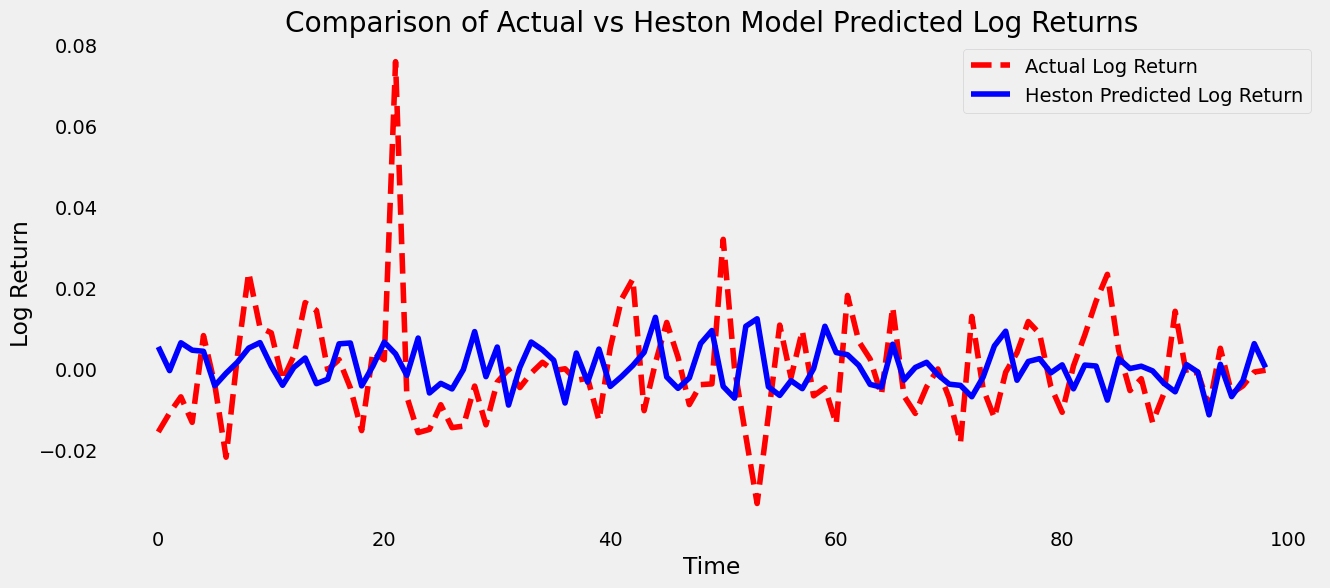

,Actual Return,Predicted Return Heston
0,-0.015701,0.005348
1,-0.011010,-0.000529
2,-0.007006,0.006362
3,-0.013316,0.004526
4,0.008134,0.004250
...,...,...
94,0.004995,0.001032
95,-0.006174,-0.006953
96,-0.004285,-0.002991
97,-0.000877,0.006136


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.optimize import minimize

# استفاده از داده‌های بازدهی لگاریتمی مدل GRU
returns = returndata.values

# تقسیم داده‌ها به 90٪ آموزش و 10٪ تست
split_percentage = 0.9
n_train = int(len(returns) * split_percentage)
train_data = returns[:n_train]
test_data = returns[n_train:]

# مدل هستون برای پیش‌بینی نوسانات
def heston_log_likelihood(params, returns):
    kappa, theta, sigma, v0, rho = params
    n = len(returns)
    v = np.zeros(n)
    v[0] = max(v0, 1e-8)  # جلوگیری از مقدار منفی یا صفر
    log_likelihood = 0

    for t in range(1, n):
        v[t] = max(v[t-1] + kappa * (theta - v[t-1]) + sigma * sqrt(max(v[t-1], 1e-8)) * np.random.normal(), 1e-8)
        log_likelihood += -0.5 * (np.log(v[t]) + (returns[t] ** 2) / v[t])

    return -log_likelihood

# مقداردهی اولیه پارامترهای مدل هستون
initial_params = [0.1, 0.02, 0.1, 0.02, 0.5]
result = minimize(heston_log_likelihood, initial_params, args=(train_data,), method='Nelder-Mead')
kappa, theta, sigma, v0, rho = result.x

# شبیه‌سازی مسیرهای آینده با مدل هستون
simulations = 1000
future_days = len(test_data)

simulated_returns = np.zeros((simulations, future_days))

for i in range(simulations):
    v = v0
    for t in range(future_days):
        v = max(v + kappa * (theta - v) + sigma * sqrt(max(v, 1e-8)) * np.random.normal(), 1e-8)
        simulated_returns[i, t] = np.random.normal(0, sqrt(v))

# محاسبه میانگین بازدهی پیش‌بینی‌شده
predicted_returns = simulated_returns.mean(axis=0)

# تبدیل داده‌های تست به DataFrame برای نمایش بهتر
test_df = pd.DataFrame(index=range(len(test_data)))
test_df['Actual Return'] = test_data
test_df['Predicted Return Heston'] = predicted_returns

# رسم نمودار مقایسه‌ای بین مدل هستون و GRU
plt.figure(figsize=(14, 6))
plt.plot(test_df.index, test_df['Actual Return'], label='Actual Log Return', color='red', linestyle='dashed')
plt.plot(test_df.index, test_df['Predicted Return Heston'], label='Heston Predicted Log Return', color='blue')
plt.title('Comparison of Actual vs Heston Model Predicted Log Returns')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.grid()
plt.show()

# نمایش مقایسه نهایی
test_df[['Actual Return', 'Predicted Return Heston']]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# محاسبه MSE
mse = mean_squared_error(test_df['Actual Return'], test_df['Predicted Return Heston'])

# محاسبه MAE
mae = mean_absolute_error(test_df['Actual Return'], test_df['Predicted Return Heston'])

# محاسبه RMSE
rmse = sqrt(mse)

# نمایش نتایج
print(f'MSE: {mse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'RMSE: {rmse:.6f}')


MSE: 0.000212
MAE: 0.010498
RMSE: 0.014572


In [ ]:
type(test_df['Predicted Return Heston'])


pandas.core.series.Series

In [ ]:
import numpy as np

# تبدیل به آرایه numpy
predicted_returns = test_df['Predicted Return Heston'].to_numpy()

# بررسی ابعاد قبل از تغییر
print("Shape before reshaping:", predicted_returns.shape)

# تغییر ابعاد به (99, 1)
predicted_returns = predicted_returns.reshape(-1, 1)

# بررسی ابعاد پس از تغییر
print("Shape after reshaping:", predicted_returns.shape)


Shape before reshaping: (99,)
Shape after reshaping: (99, 1)


In [ ]:

import numpy as np

# تبدیل به آرایه numpy
predicted_returns = =predicted_returns.to_numpy()

# بررسی ابعاد قبل از تغییر
print(predicted_returns.shape)

# تغییر ابعاد به (99, 1)
predicted_returns = predicted_returns.reshape(-1, 1)

# بررسی ابعاد پس از تغییر
print(predicted_returns.shape)


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [ ]:
 test_data['Predicted Return Heston']





IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
predict_gru.shape , predicted_returns.shape , y_test.shape

((99, 1), (99, 1), (99, 1))

In [ ]:
pip install pyswarm

In [ ]:
import numpy as np
from pyswarm import pso

# داده‌های فرضی (شما باید این‌ها را با داده‌های واقعی خود جایگزین کنید)
# اطمینان از تبدیل آرایه‌ها به بردارهای 1-بعدی
predicted_prices = predict_gru.flatten()  # تبدیل به بردار 1-بعدی
closest_simulated_path = predicted_returns.flatten()  # تبدیل به آرایه numpy و سپس flatten
real_data = y_test.flatten()  # داده واقعی نیز به بردار 1-بعدی تبدیل شود

# تعداد روزها
n_days = len(real_data)

# تعریف تابع هدف
def objective_function(weights):
    """
    تابع هدف: کمینه‌سازی خطای پیش‌بینی ترکیبی.
    weights: آرایه‌ای از وزن‌ها به شکل [w1_1, w2_1, w1_2, w2_2, ..., w1_n, w2_n]
    """
    # تبدیل آرایه وزن‌ها به ماتریس ضرایب
    weights_matrix = weights.reshape(n_days, 2)
    # ترکیب پیش‌بینی‌ها با وزن‌ها برای هر روز
    combined_predictions = np.sum(weights_matrix * np.column_stack((predicted_prices, closest_simulated_path)), axis=1)
    # محاسبه خطای MSE
    mse = np.mean((real_data - combined_predictions) ** 2)
    return mse

# محدوده وزن‌ها (بدون محدودیت خاصی)
# برای هر روز دو وزن داریم (w1_i, w2_i)
lb = [-1] * (2 * n_days)  # lower bounds (می‌توانید این مقادیر را تغییر دهید)
ub = [1] * (2 * n_days)  # upper bounds (می‌توانید این مقادیر را تغییر دهید)

# اجرای الگوریتم PSO (بدون محدودیت)
optimal_weights, optimal_mse = pso(objective_function, lb, ub)

# تبدیل وزن‌های بهینه به ماتریس ضرایب
optimal_weights_matrix = optimal_weights.reshape(n_days, 2)

# نمایش نتایج
print("Optimal Weights Matrix (PSO):")
print(optimal_weights_matrix)
print("Optimal MSE:", optimal_mse)

# ترکیب پیش‌بینی‌ها با وزن‌های بهینه برای هر روز
final_predictions = np.sum(optimal_weights_matrix * np.column_stack((predicted_prices, closest_simulated_path)), axis=1)

# محاسبه خطاهای نهایی
final_mse = np.mean((real_data - final_predictions) ** 2)
final_rmse = np.sqrt(final_mse)
final_mae = np.mean(np.abs(real_data - final_predictions))

print("Final MSE:", final_mse)
print("Final RMSE:", final_rmse)
print("Final MAE:", final_mae)

Stopping search: Swarm best objective change less than 1e-08
Optimal Weights Matrix (PSO):
[[ 0.63786713 -0.35040977]
 [ 0.40780191  0.28393452]
 [-0.09764981 -0.96893176]
 [ 0.45781715  0.67316241]
 [-0.1285188   0.00893489]
 [-0.54185701  0.51285319]
 [-0.11590463  0.2029562 ]
 [-0.44840285 -0.83341804]
 [ 0.16116352  1.        ]
 [-0.98977542  0.7437879 ]
 [-0.48422222  0.51799189]
 [ 0.86778427  0.35232085]
 [-0.9990337   0.10574492]
 [-0.71685797  0.14437918]
 [ 0.3348283  -1.        ]
 [ 0.11048457 -0.19695975]
 [ 0.12462693 -0.99986195]
 [ 0.63251523  0.87147168]
 [ 0.07834767  1.        ]
 [ 1.          0.55178385]
 [-0.87957667 -0.6083559 ]
 [-0.71728539  1.        ]
 [-0.4185718  -0.40820119]
 [-0.15371835 -0.78448827]
 [-0.03275027  0.78051581]
 [-0.05401685  0.74702672]
 [ 0.6220264   0.95222928]
 [-0.16151916 -0.34446807]
 [-0.26292608 -0.82928013]
 [ 1.         -0.03522283]
 [ 0.42539398  0.35533393]
 [-0.17822869 -0.00148216]
 [ 0.56711842 -0.28583007]
 [ 0.60397855  0.1

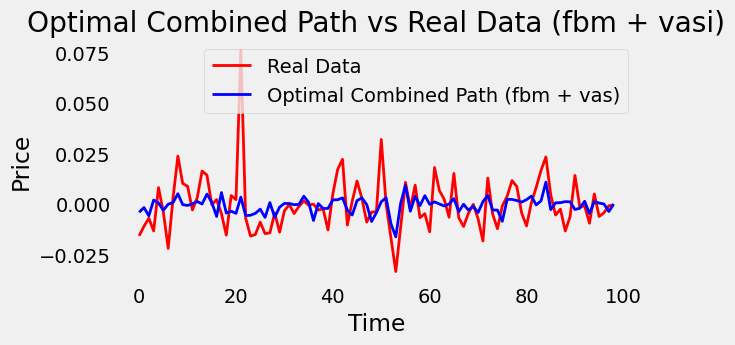

In [ ]:
# رسم نمودار
plt.figure(figsize=(6, 3))
plt.plot(real_data, lw=2, color='red', label='Real Data')
plt.plot(final_predictions, lw=2, color='blue', label='Optimal Combined Path (Heston + GRU)')
plt.title("Optimal Combined Path vs Real Data (fbm + vasi)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

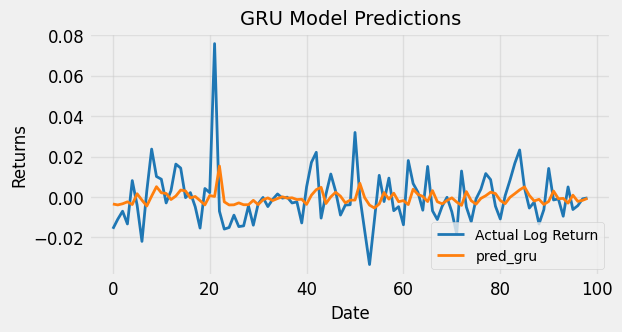

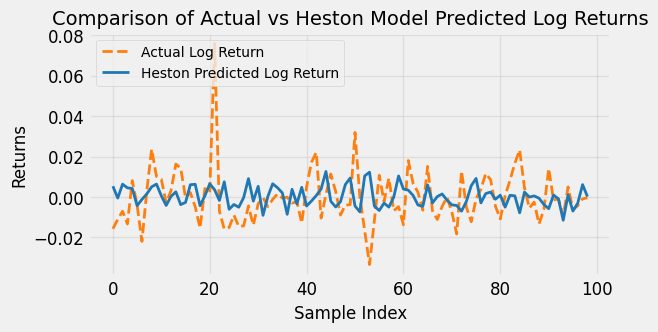

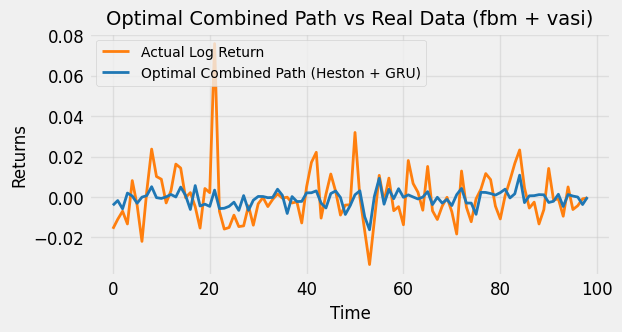

In [ ]:
import matplotlib.pyplot as plt

# تنظیمات عمومی برای تمام نمودارها
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12, 'lines.linewidth': 2, 'grid.alpha': 0.5})

# نمودار اول: پیش‌بینی‌ها
plt.figure(figsize=(6, 3))
plt.plot(y_test, color='#1f77b4', label='Actual Log Return')  # رنگ مشابه (آبی)
plt.plot(predict_gru, color='#ff7f0e', label='pred_gru')  # رنگ مشابه (نارنجی)
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('GRU Model Predictions')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(range(len(test_df)), test_df['Actual Return'], label='Actual Log Return', color='#ff7f0e', linestyle='--')  # محور x بر اساس تعداد نمونه‌ها
plt.plot(range(len(test_df)), test_df['Predicted Return Heston'], label='Heston Predicted Log Return', color='#1f77b4')
plt.title('Comparison of Actual vs Heston Model Predicted Log Returns')
plt.xlabel('Sample Index')  # تغییر نام محور x
plt.ylabel('Returns')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.show()


# نمودار سوم: مقایسه داده‌های واقعی با مسیر بهینه ترکیب‌شده
plt.figure(figsize=(6, 3))
plt.plot(real_data, lw=2, color='#ff7f0e', label='Actual Log Return')  # رنگ مشابه (نارنجی)
plt.plot(final_predictions, lw=2, color='#1f77b4', label='Optimal Combined Path (Heston + GRU)')  # رنگ مشابه (آبی)
plt.title("Optimal Combined Path vs Real Data (fbm + vasi)")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.show()

